In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import datetime
import torch
import copy
import importlib

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pytorch_model.abstract_lstm as abstract_lstm
from sklearn.metrics import mean_squared_error 
import helpers.pre_processing as preprocessing
from dateutil.relativedelta import relativedelta
import helpers.post_processing as postprocessing
import helpers.evaluation as eval
from pytorch_model.abstract_lstm import Abstract_Lstm
#importlib.reload(abstract_Lstm)
importlib.reload(preprocessing)
importlib.reload(postprocessing)
importlib.reload(eval)

<module 'helpers.evaluation' from '/Users/tom.wuesten/privat_code/CLV/src/CLV/helpers/evaluation.py'>

In [217]:
# load the data from the source file
# only need the account_id (a primary key, customer identifier) and the date columns
# convert the date column from strings like "930101" into a proper datetime format
df = pd.read_csv(filepath_or_buffer='data/trans.zip', 
                 usecols=['account_id', 'date'], 
                 parse_dates=['date'])

In [218]:
df.head()

,account_id,date
0,2378,1993-01-01
1,576,1993-01-01
2,704,1993-01-01
3,3818,1993-01-01
4,1972,1993-01-02


In [219]:
# define the training (calibration) and prediction (holdout) period

training_start = '1993-01-01'
training_end   = '1995-12-31'
holdout_start  = '1996-01-01'
holdout_end    = '1998-12-31'
date_format    = '%Y-%m-%d'

In [220]:
# display basic stats

cohort_accounts = df.groupby('account_id').min().query(
    'date <= @training_end').reset_index()['account_id'].tolist()

df = df.query('account_id in @cohort_accounts')
df = df.sort_values(by='account_id').reset_index(drop=True)

print(f"Accounts in dataset:  {len(df['account_id'].unique())}")
print(f"Total transactions: {len(df)}")

Accounts in dataset:  2239
Total transactions: 744015


In [221]:
# count aggregate stats

aggregate_counts = df.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts = aggregate_counts.groupby(['year', 'week']).agg({'account_id': 'count', 'date': 'min'}).reset_index()

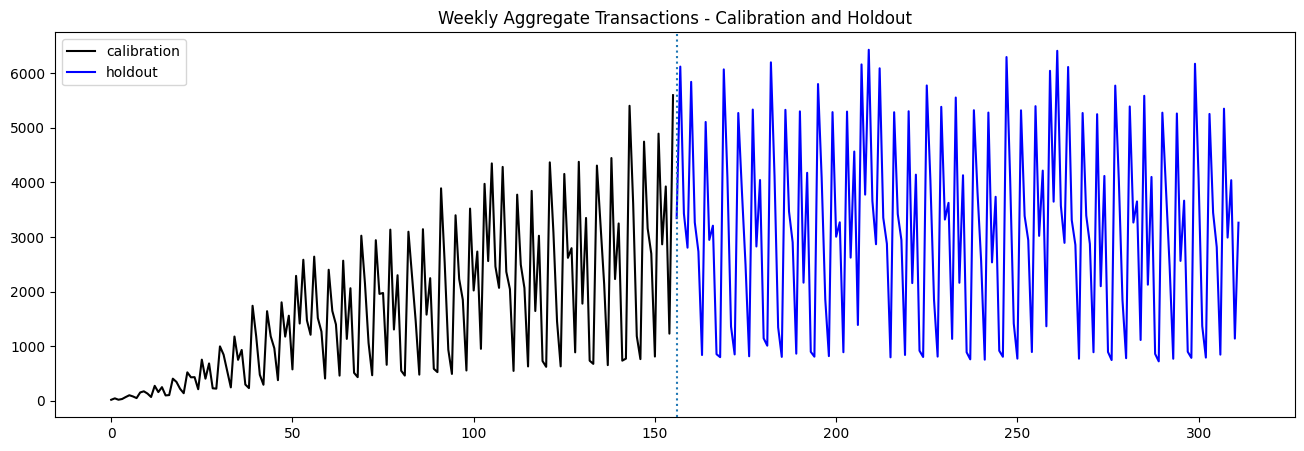

In [222]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end].index, 
         aggregate_counts[aggregate_counts.date <= training_end]['account_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['account_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end]), linestyle=':')
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("plots_valendin/calibration_holdout.png", dpi=600)
plt.show()

# note the prominent monthly pattern with spiky first weeks

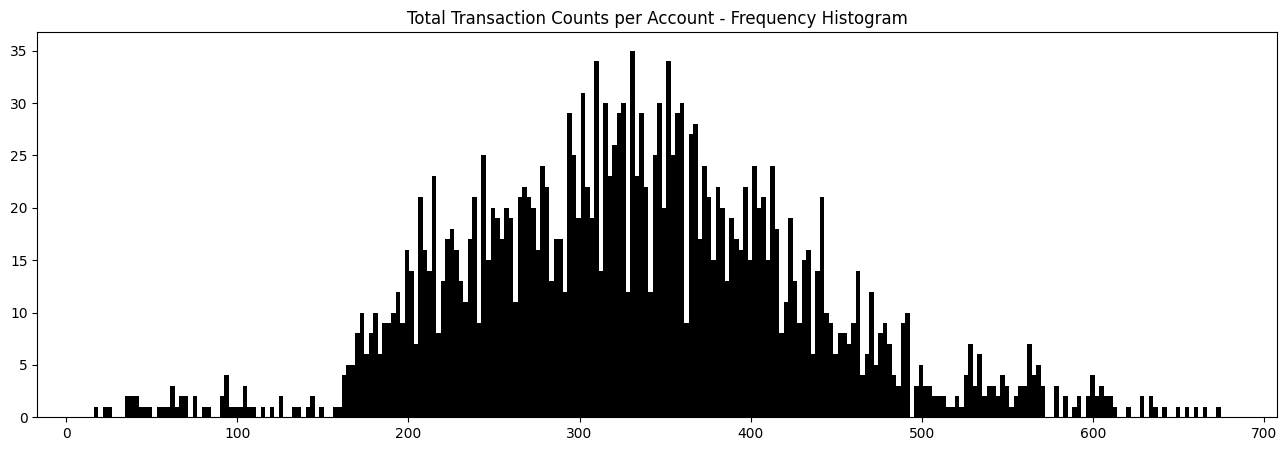

In [223]:
# display the distribution of total transaction counts per customer

transactions_per_account = list(df.groupby('account_id').count()['date'])

plt.figure(figsize=(16,5))
plt.hist(transactions_per_account, bins=250, color='black')
plt.title('Total Transaction Counts per Account - Frequency Histogram')
plt.savefig("plots_valendin/transactions_histogram.png", dpi=600)
plt.show()

In [224]:
# generate a list of dates between two dates
def date_range(start, end):
    start = datetime.datetime.strptime(start, date_format)
    end = datetime.datetime.strptime(end, date_format)
    r = (end+datetime.timedelta(days=1)-start).days
    return [start+datetime.timedelta(days=i) for i in range(r)]

# prepare a template for training samples to be filled with each customer's data
ed = pd.DataFrame(date_range(training_start, holdout_end), columns=['date'])
ed['year'] = ed['date'].dt.year      # 0-indexing 
ed['week'] = (ed['date'].dt.dayofyear // 7).clip(upper=51)

# save the holdout calendar for later use
holdout_calendar = ed[ed['date'] >= holdout_start].drop(columns=['date']).drop_duplicates().drop(columns=['year'])

# samples are training inputs
# targets are training labels
# calibration is stored for later use in prediction
# holdout is data not used in training
samples, targets, calibration, holdout = [], [], [], []
trans = 0 # total transaction count across all individuals

max_trans_per_week = 0
max_trans_cust = []

# shuffle data randomly
ids = df['account_id'].unique()
random.shuffle(ids)

# build a record for each customer
for account in tqdm(ids, desc='preparing dataset'):
    # take the data of single user, 
    subset = df.query('account_id == @account').groupby(
        ['date']).count().reset_index()
    user = subset.copy(deep=True)
    user = user.rename(columns={'account_id': 'transactions'})
    # copy the empty frame
    frame = ed.copy(deep=True)
    # insert customer ID
    frame['account_id'] = account
    # merge customer data into the empty frame
    frame = frame.merge(user, on=['date'], how='left')
    # aggregate weekly transactions
    frame = frame.groupby(['year', 'week']).agg(
        {'transactions': 'sum', 
         'date': 'min'}).sort_values(['date']).reset_index()
    # there is a small number of ids with 7 and more transactions per week
    # to make the job easier for the model, we can clip the value at 6:
    # frame['transactions'] = frame['transactions'].clip(upper=6)
    # this will however make the assertion following this block fail
    max_trans = max(frame['transactions'])
    max_trans_per_week = max(max_trans_per_week, max_trans)
    max_trans_cust.append(max_trans)
    # keep a count of the total transactions
    trans += user['transactions'].sum()
    # training sequences of everything until the holdout period
    training = frame[frame['date'] < holdout_start]
    training = training.drop(columns=['date', 'year']).astype(int)
    # store for later use
    calibration.append(training)
    # training sample: calibration sequence sans the final element
    sample = training[:-1].values # not the last row
    #print(sample)
    samples.append(sample)
    # target labels: sequence of transaction counts starting 
    # with the 2nd element. At each step of the training
    # we use a row from the train_samples element as our input, 
    # and predict the corresponding element from train_targets
    target = training.loc[1:, 'transactions'].values    
    targets.append(target)
    # keep holdout sequence to compare with predictions
    hold = frame[frame['date'] >= holdout_start]
    hold = hold.drop(columns='date')
    holdout.append(hold)
       
# check that we didn't lose any transactions along the way
assert trans == len(df)

print(f"Maximum transactions per account_id per time-unit found: {int(max_trans_per_week)}")

# create a validation set which won't be used in training
# we've already shuffled the data so we just grab the tail end
# of the list for validation, the rest is the training set
VALIDATION_SPLIT = 0.1
validation_size = round(len(samples) * VALIDATION_SPLIT)
valid_samples, valid_targets = samples[-validation_size:], targets[-validation_size:]
train_samples, train_targets = samples[:-validation_size], targets[:-validation_size]

# def decode_sample(sample, target):
#     return ({'week'       : tf.cast(tf.expand_dims(sample[:, 0], axis=-1), 'int32'), 
#              'transaction': tf.cast(tf.expand_dims(sample[:, 1], axis=-1), 'int32')},
#              tf.cast(tf.expand_dims(target, axis=-1), 'int32'))

# number of samples in each dataset
no_train_samples, no_valid_samples = len(train_samples), len(valid_samples)

# batch size is the number of samples used to calculate
# the loss gradient at each step during the training
BATCH_SIZE_TRAIN = 32   

# for prediction this doesn't matter appart from memory constraint, 
# if you run out of memory you might need to set this to a smaller value 
BATCH_SIZE_PRED = no_valid_samples  
# validation loss also calculated in one step
BATCH_SIZE_VALID = no_valid_samples

# # lenght of each training sequence:


# train_dataset = (tf.data.Dataset.from_tensor_slices((train_samples, train_targets))
#                 .map(decode_sample)
#                 .batch(BATCH_SIZE_TRAIN)
#                 .repeat())

# valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_samples, valid_targets))
#                  .map(decode_sample).batch(BATCH_SIZE_VALID).repeat())

preparing dataset:   0%|          | 0/2239 [00:00<?, ?it/s]

Maximum transactions per account_id per time-unit found: 11


### Create Dataset and convert to Tensors

In [225]:
valid_samples, valid_targets = samples[-validation_size:], targets[-validation_size:]
train_samples, train_targets = samples[:-validation_size], targets[:-validation_size]

In [ ]:
x_train[:,:,0].unsqueeze(-1).shape

In [226]:
seq_len = samples[0].shape[0]
x_train = torch.Tensor(train_samples)
x_train = x_train.long()
y_train = torch.Tensor(train_targets)
y_train = y_train.long()
y_train = torch.unsqueeze(y_train, dim=-1)

In [ ]:
x_train[:,:,0].unsqueeze(-1).shape

In [227]:
x_train_dict = {}

In [228]:
x_train_dict["weeks"] = x_train[:,:,0].unsqueeze(-1)

In [229]:
x_train_dict["trans"] = x_train[:,:,1].unsqueeze(-1)

In [230]:
x_valid = torch.Tensor(valid_samples)
x_valid = x_valid.long()
y_valid = torch.Tensor(valid_targets)
y_valid = y_valid.long()
y_valid = torch.unsqueeze(y_valid, dim=-1)

In [231]:
x_valid_dict = {}
x_valid_dict["weeks"] = x_valid[:,:,0].unsqueeze(-1)
x_valid_dict["trans"] = x_valid[:,:,1].unsqueeze(-1)

In [232]:
class MyDataset(Dataset):
    def __init__(self, features_dict, targets):
        self.data = features_dict
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        features = {k: v[idx] for k, v in self.data.items()}
        return features, self.targets[idx]

# create the dataset

train_dataset = MyDataset(x_train_dict, y_train)
valid_dataset = MyDataset(x_valid_dict, y_valid)

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
class LSTMModel(pl.LightningModule):
    def __init__(self, seq_len, max_weeks, max_trans, stateful):
        super(LSTMModel, self).__init__()

        def emb_size(feature_max: int):
            return int(feature_max ** 0.5) + 1

        self.stateful = stateful
        self.max_weeks = max_weeks
        self.max_trans = max_trans
        self.embdedding_week = nn.Embedding(self.max_weeks, emb_size(self.max_weeks))
        self.embedding_transaction = nn.Embedding(self.max_trans, emb_size(self.max_trans))
        self.lstm = nn.LSTM(input_size=12, hidden_size=128, dropout=0.5, batch_first=True)
        self.output_layer = nn.Linear(in_features=128, out_features=12)

    def reset_hidden_state(self, x):
        self.hidden = (torch.zeros(1, x.size(0), 128).to(self.device),
                       torch.zeros(1, x.size(0), 128).to(self.device))

    def forward(self, x):
        if not self.stateful:
            self.reset_hidden_state(x)

        embedded_results = []
        x1 = x[:, :, 0].unsqueeze(-1)
        x2 = x[:, :, 1].unsqueeze(-1)

        embedded_results.append(self.embdedding_week(x1))
        embedded_results.append(self.embedding_transaction(x2))

        for i in range(2):
            embedded_results[i] = embedded_results[i].squeeze(2)

        stacked_tensors = torch.cat(embedded_results, 2)
        lstm_output, self.hidden = self.lstm(stacked_tensors, self.hidden)
        out = self.output_layer(lstm_output)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fn = torch.nn.CrossEntropyLoss() 
        loss = loss_fn(y_hat.permute(0,2,1),y.squeeze())
        self.log("train_loss", loss)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fn = torch.nn.CrossEntropyLoss() 
        loss = loss_fn(y_hat.permute(0,2,1),y.squeeze())
        
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.log("val_loss", avg_loss)
        return {'val_loss': avg_loss}

In [ ]:
from pytorch_lightning import Trainer


logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = Trainer(logger=logger)

# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor="val_loss")

In [ ]:
%load_ext tensorboard

In [ ]:
model = LSTMModel(seq_len=155,max_weeks=52,max_trans=12,stateful=False)

trainer = pl.Trainer(max_epochs=10,callbacks=[checkpoint_callback], logger=logger )
trainer.fit(model, train_dataloader, valid_dataloader)

In [ ]:
PATH = "lightning_logs/version_2/checkpoints/epoch=9-step=630.ckpt"

# uses in_dim=128, out_dim=10
model_lightning = model.load_from_checkpoint(PATH, seq_len=155,max_weeks=52,max_trans=12,stateful=True)

## Playground

In [ ]:
embedded_results = []
embdedding_week = nn.Embedding(52,8) # Shape(52,8)
embedding_transaction = nn.Embedding(12,4) # Shape(12,4)
h_0 = torch.zeros(1, x_train.size(0), 128)  # initialize hidden state before each pass

c_0 = torch.zeros(1, x_train.size(0), 128)  # initialize cell state before each pass
output_layer = nn.Linear(in_features=128,out_features=12)
softmax = nn.Softmax(dim=2)
lstm = nn.LSTM(input_size=12,
hidden_size=128,
batch_first=True)
x1 = torch.LongTensor(x_train[:,:,0].unsqueeze(-1))
x2 = torch.LongTensor(x_train[:,:,1].unsqueeze(-1))
#print(x1.shape)
#print(x2.shape)
embedded_results.append(embdedding_week(x1))
embedded_results.append(embedding_transaction(x2))
for i in range(2):
    embedded_results[i]= embedded_results[i].squeeze(2)
stacked_tensors = torch.cat(embedded_results,2)
output, (hn, cn) = lstm(stacked_tensors, (h_0, c_0))
#out = output[-1, :, :]  # (batch, hidden_size)
dense = output_layer(output)
out = softmax(dense)

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [ ]:
torch.randn(3, 5)

In [ ]:
target = torch.randn(3, 5).softmax(dim=1)
target

In [ ]:
y_train.shape

In [ ]:
out[0][0]

In [ ]:
print(f'shape {x_train.shape=} and {y_train.shape=}')
print(f'shape {x_valid.shape=} and {y_valid.shape=}')

The TrainDataset describes following: 2015 accounts with a timeseries of 155 weeks and 2 input features -> transactions and week
The TrainDataset describes following: 2015 accounts with a timeseries of 155 weeks and 1 output features -> output individuell prediction for one account

In [233]:
max_features = {"weeks": 52, "trans": 12}

In [ ]:
next(iter(max_features.values()))

In [ ]:
def emb_size(feature_max: int):
      return int(feature_max ** 0.5) + 1
result = 0
for key, value in max_features.items():
     result += emb_size(value)

In [272]:
class LSTMModel(nn.Module):

  def __init__(self,
    max_features,
    stateful,
    ):
    super(LSTMModel, self).__init__()

    def emb_size(feature_max: int):
      return int(feature_max ** 0.5) + 1
    # Embeddings for LSTM
    self.stateful = stateful
    self.max_features = max_features
    self.embeddings = {}
    self.input_lstm = 0
    for key, value in max_features.items():
      self.embeddings[key] =  nn.Embedding(value, emb_size(value))
      self.input_lstm += emb_size(value)
    # batch_first=True causes input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(input_size=self.input_lstm,
    hidden_size=128,
    batch_first=True)
    self.output_layer = nn.Linear(in_features=128,out_features=12)  
  def reset_hidden_state(self, x):
    self.hidden = (
        torch.zeros(  1,next(iter(x.values())).size(0), 128),
        torch.zeros( 1, next(iter(x.values())).size(0), 128)
    )

  def forward(self, x):
    if not self.stateful:
      self.reset_hidden_state(x)
    embedded_results = []
    if x.keys() == self.max_features.keys():
      for key, value in x.items():
        embedded_results.append(self.embeddings[key](value))
    else:
      return "Wrong configuration of features"
    #x1 = x[:,:,0].unsqueeze(-1)
    #x2 = x[:,:,1].unsqueeze(-1)
    #print(x1.shape)
    #print(x2.shape)
    
    #embedded_results.append(self.embedding_transaction(x2))
    for i in range(len(embedded_results)):
      embedded_results[i]= embedded_results[i].squeeze(2)
    stacked_tensors = torch.cat(embedded_results,2)
    
    #stacked_tensors = stacked_tensors.unsqueeze(1).permute(1,2,0)
    #print(stacked_tensors.size(-1))
    #stacked_tensors = stacked_tensors.permute(0,2,1)
    #print(stacked_tensors.shape)
    lstm_output, self.hidden = self.lstm(stacked_tensors, self.hidden) 
    # lstm_output torch.Size([2015, 155, 128])
    #out = lstm_output[-1, :, :]  # (batch, hidden_size)
    #print(out.shape)
    out = self.output_layer(lstm_output)  # (batch, 1)
    return out
    return self.output_layer(out) #Pytroch Lossfunction Cross Entropy has Softmax as Activation included -> no need to declare here


model = LSTMModel(max_features=max_features, stateful=False)

In [235]:
def train(model, num_epochs, learning_rate, loss_function, training_loader, validation_loader):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss=float("inf")
    best_model_dict=model.state_dict()
    best_epoch=0
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    model.train()
    for epoch in range(num_epochs):
        for i, data in enumerate(training_loader):
            inputs, labels = data
            model.reset_hidden_state(x=inputs)
            trainY_pred = model(inputs)  # predict train with the current model
            optimizer.zero_grad()
            train_loss = loss_function(trainY_pred.permute(0,2,1),labels.squeeze())
            #train_loss = loss_function(trainY_pred, torch.max(labels, dim=0)[0]) # compute the loss ("how bad is our model?")
            train_loss.backward() # propagate the loss backwards through the network
            #print(train_loss.item())
            optimizer.step() # update weights and biases
        train_hist[epoch] = train_loss.item()
        for i, vdata in enumerate(validation_loader):
            with torch.no_grad():
                vinputs, vlabels = vdata
                valY_pred=model(vinputs)
                #val_loss=loss_function(valY_pred,torch.max(vlabels, dim=0)[0])
                val_loss = loss_function(valY_pred.permute(0,2,1),vlabels.squeeze())
                if epoch > 5:
                    if (val_loss<best_val_loss):
                        best_val_loss=val_loss
                        best_model_dict=copy.deepcopy(model.state_dict())
                        best_epoch=epoch
        test_hist[epoch] = val_loss.item()   
        if epoch % 1000 == 999:
            print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss.item(), val_loss.item()))
    
    if epoch > 5:
        model.load_state_dict(best_model_dict)
        print("Best Epoch: %d, loss: %1.5f" % (best_epoch, best_val_loss.item()))

    return best_model_dict, train_hist, test_hist

In [236]:
loss_fn = torch.nn.CrossEntropyLoss() 
#optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
best_model_dict, train_loss, val_loss = train(model=model,num_epochs=10,learning_rate=0.01,loss_function=loss_fn,training_loader=train_loader,validation_loader=valid_loader)

Best Epoch: 9, loss: 0.50155


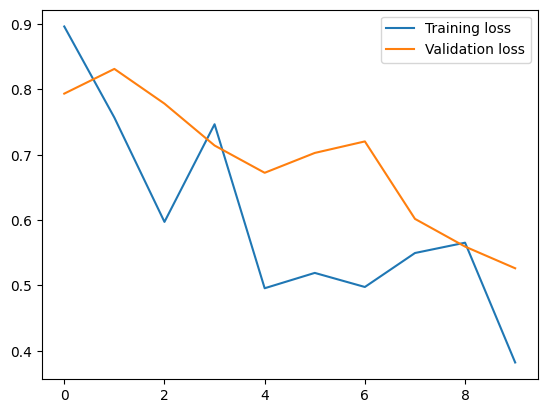

In [237]:
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()

In [273]:
model_pred = LSTMModel(max_features=max_features, stateful=True)
model_pred.load_state_dict(best_model_dict)

<All keys matched successfully>

In [274]:
# before we can start forecasting, we feed in the entire previous history
# for each individual, to build up the cell-state memory which represents
# each individual past history. After we feed in the last element of the 
# training sequence, the model output will be the first forecasted value
# for the holdout period. To make things easy, we first put all calibration
# data into a individuals*sequence_length*number_of_features shaped tensor.
# We call this object "the seed".

seed = np.array([df.values for df in calibration], dtype=np.float32)
print(f"The seed shape is individuals ({seed.shape[0]}) X calibration length ({seed.shape[1]}) X number of features ({seed.shape[2]})")

no_samples = seed.shape[0]
no_timesteps = seed.shape[1]
no_features = seed.shape[2]
no_batches = int(np.ceil(no_samples/BATCH_SIZE_PRED))

# pad the last batch with 0s if needed and then 
# remove the corresponding predictions after we're done predicting
if seed.shape[0] < (BATCH_SIZE_PRED * no_batches):
    padding = np.zeros(((BATCH_SIZE_PRED * no_batches) - no_samples, no_timesteps, no_features))
    seed = np.concatenate((seed, padding), axis=0)

The seed shape is individuals (2239) X calibration length (156) X number of features (2)


In [275]:
def predict(model, batch):
    with torch.no_grad():
        y_pred_dist = model(batch)
        _, y_pred_tags = torch.max(y_pred_dist, dim=2)
        y_pred = y_pred_tags.unsqueeze(-1)
    return np.array(y_pred)

In [292]:
# simulate several independent scenarios 
# we take the mean to remove sampling noise
# most improvement with 20-30 independent simulations
# generating one scenario takes about 2mins on dual-core laptop
# simulated scenarios can be generated in parallel
NO_SCENARIOS = 2

scenarios = []
# how many time-steps does the holdout have
holdout_length = holdout[0].shape[0]

for _ in tqdm(range(NO_SCENARIOS), desc='simulating scenarios'):
    batches_predicted = []

    for j in range(no_batches):
        pred = []
        # in the beginning reset the model memory
        #model_pred.reset_hidden_state()
        
        # calculate batch start and end indexes
        batch_start = j * BATCH_SIZE_PRED
        batch_end = (j + 1) * BATCH_SIZE_PRED
        # batch is a dictionary which links model inputs with lists of sample features
        batch = {}        
        batch['weeks'] = torch.tensor(seed[batch_start:batch_end, :, 0]).long()
        batch['trans'] = torch.tensor(seed[batch_start:batch_end, :, 1]).long()
        #batch =  torch.tensor(seed[batch_start:batch_end, :,:]).long()   
        # pass the batch through the prediction model: here we discard the output
        # since we're not interested in in-sample prediction (maybe you are?), we
        # just need to build up that internal cell-state memory
        model_pred.reset_hidden_state(batch)
        #model.reset_hidden_state(batch)
        #model_lightning.reset_hidden_state(batch)
        prediction = predict(model_pred,batch)
        #prediction = model_lightning.predict(batch)              
        # we do however take the very last element of each predicted sequence: 
        # as this is the first forecasted value
        # pred.append(prediction[:, -1:, :])
        pred.append(prediction[:, :, :])
        # now lets forecast all the future steps autoregressively
        for i in range(holdout_length - 1):
            for calendar_feature in ['week']:                        
                feature = np.repeat(holdout_calendar.iloc[i][calendar_feature], BATCH_SIZE_PRED)
                feature = feature[:, np.newaxis, np.newaxis]
            #print(pred[-1].shape)
            batch = {}        
            batch['weeks'] = torch.tensor(feature).long()
            batch['trans'] = torch.tensor(pred[-1][:, -1:, :]).long()
            prediction = predict(model_pred,batch)
            #prediction = model_lightning.predict(batch)
            pred.append(prediction[:, :, :])
        batches_predicted.append(pred)

    scenarios.append(batches_predicted)

simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

In [293]:
z = []
for scenario in scenarios:
    y = []
    for batch in scenario:
        x = []
        for time_step in batch:
            if type(time_step) == np.ndarray:
                x.append(time_step) # x -> shape (batch x Time x value) -> first batch is (224 x 155 x 1) -> after (224 x 1 x 1) (autoregressiv)
            else:
                complete_time_step = np.concatenate(time_step, axis=-1)
                x.append(complete_time_step)
        y.append(np.concatenate(x, axis=1)) # combining all time steps -> (224 x 311 x 1)
    # cut off the padding, if any
    z.append(np.concatenate(y, axis=0)[:no_samples, :, :]) # combine all batches -> (2239 x 311 x 1)

# predictions is a multidimensional array holding all the predicted values
predictions = np.asarray(z)

In [294]:
# the shape of the result is: (NO_SCENARIOS, no_ids, sequence_lenght, features)
predictions.shape

(2, 2239, 311, 1)

In [295]:
# this covers in-sample and out of sample periods
prediction_calendar = ed[['year', 'week']].drop_duplicates().reset_index(drop=True)[1:]

In [296]:
predictions.shape

(2, 2239, 311, 1)

In [297]:
# combine calendar with results
aggregate_prediction = prediction_calendar

# take the mean across multiple simulations to create the final prediction
aggregate_prediction['transactions'] = np.squeeze(np.sum(np.mean(predictions, axis=0), axis=0))
aggregate_prediction = aggregate_prediction.reset_index()

In [298]:
prediction_calendar

,year,week,transactions
1,1993,1,0.0
2,1993,2,9034.0
3,1993,3,20073.0
4,1993,4,19999.0
5,1993,5,19985.0
...,...,...,...
307,1998,47,23571.0
308,1998,48,13369.0
309,1998,49,13358.0
310,1998,50,21404.0


In [299]:
# individual predictions are stored as a table where rows are indexed with customer ids 
# and columns represent the predicted transaction counts over the weekly holdout periods

individual_predictions = pd.DataFrame(np.squeeze(np.mean(predictions, axis=0))).round(2).set_index(pd.Series(df['account_id'].unique()))

print('first 5 predicted individuals:\n')
print(individual_predictions.head())

first 5 predicted individuals:

   0    1    2    3    4    5     6     7     8     9    ...  301   302   303  \
1  0.0  4.0  9.0  9.0  9.0  6.0  11.0  11.0  11.0  11.0  ...  6.0  11.0   6.0   
2  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0   6.0   
6  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0  11.0   
8  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0  11.0   
9  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0   6.0   6.0   

    304   305   306  307  308   309   310  
1   6.0   6.0   6.0  6.0  6.0   6.0  11.0  
2   6.0  11.0  11.0  6.0  6.0  11.0  11.0  
6  11.0  11.0  11.0  6.0  6.0   6.0  11.0  
8  11.0  11.0  11.0  6.0  6.0   6.0  11.0  
9   6.0   6.0   6.0  6.0  6.0   6.0   6.0  

[5 rows x 311 columns]


In [300]:
# individual predictions are stored as a table where rows are indexed with customer ids 
# and columns represent the predicted transaction counts over the weekly holdout periods

individual_predictions = pd.DataFrame(np.squeeze(np.mean(predictions, axis=0))).round(2).set_index(pd.Series(df['account_id'].unique()))

print('first 5 predicted individuals:\n')
print(individual_predictions.head())

first 5 predicted individuals:

   0    1    2    3    4    5     6     7     8     9    ...  301   302   303  \
1  0.0  4.0  9.0  9.0  9.0  6.0  11.0  11.0  11.0  11.0  ...  6.0  11.0   6.0   
2  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0   6.0   
6  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0  11.0   
8  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0  11.0  11.0   
9  0.0  4.0  9.0  9.0  9.0  7.0   8.0   8.0  11.0  11.0  ...  6.0   6.0   6.0   

    304   305   306  307  308   309   310  
1   6.0   6.0   6.0  6.0  6.0   6.0  11.0  
2   6.0  11.0  11.0  6.0  6.0  11.0  11.0  
6  11.0  11.0  11.0  6.0  6.0   6.0  11.0  
8  11.0  11.0  11.0  6.0  6.0   6.0  11.0  
9   6.0   6.0   6.0  6.0  6.0   6.0   6.0  

[5 rows x 311 columns]


In [301]:
one_scenario = pd.DataFrame(np.squeeze(predictions[0])).astype(int).set_index(pd.Series(df['account_id'].unique()))
print('print first 5 predicted individuals in first scenario:\n')
print(one_scenario.head())

print first 5 predicted individuals in first scenario:

   0    1    2    3    4    5    6    7    8    9    ...  301  302  303  304  \
1    0    4    9    9    9    6   11   11   11   11  ...    6   11    6    6   
2    0    4    9    9    9    7    8    8   11   11  ...    6   11    6    6   
6    0    4    9    9    9    7    8    8   11   11  ...    6   11   11   11   
8    0    4    9    9    9    7    8    8   11   11  ...    6   11   11   11   
9    0    4    9    9    9    7    8    8   11   11  ...    6    6    6    6   

   305  306  307  308  309  310  
1    6    6    6    6    6   11  
2   11   11    6    6   11   11  
6   11   11    6    6    6   11  
8   11   11    6    6    6   11  
9    6    6    6    6    6    6  

[5 rows x 311 columns]


In [302]:
in_sample = aggregate_prediction[:-holdout_length]
out_of_sample = aggregate_prediction[-holdout_length:]

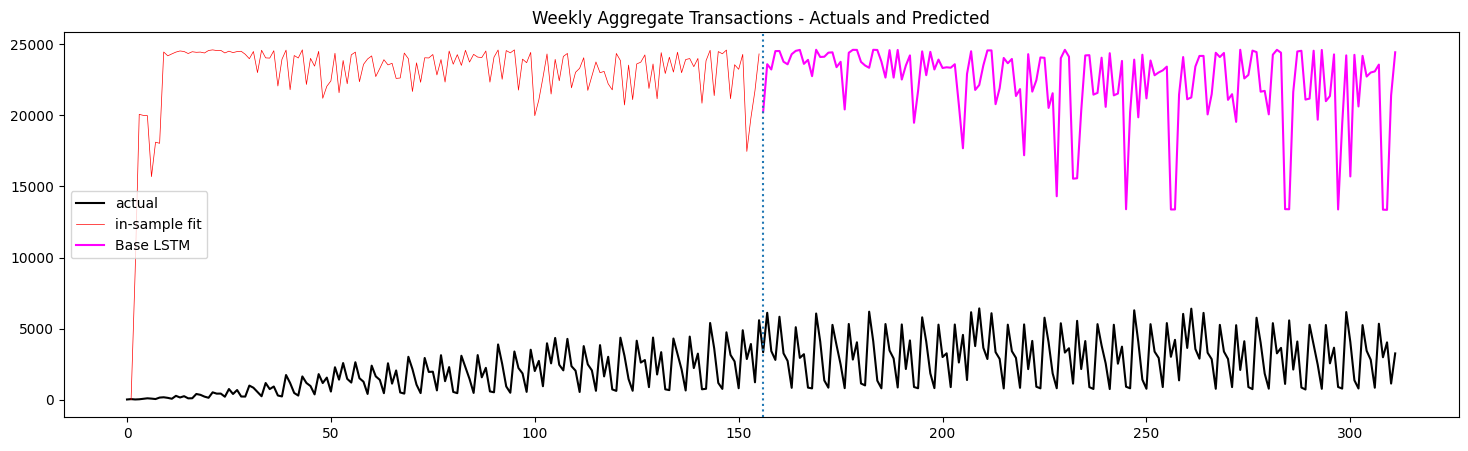

In [303]:
# plot calibration and holdout with prediction
plt.figure(figsize=(18,5))
plt.plot(aggregate_counts.index, aggregate_counts['account_id'], color='black', label='actual')
plt.plot(in_sample['index'], in_sample['transactions'], color='Red', lw=0.5, label='in-sample fit')
plt.plot(out_of_sample['index'], out_of_sample['transactions'], color='magenta', label='Base LSTM')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end]), linestyle=':')
plt.title('Weekly Aggregate Transactions - Actuals and Predicted')
plt.legend()
plt.savefig("plots_valendin/actuals_prediction.png", dpi=600)
plt.show()

# note the in sample fit is so tight here it's difficult to see

In [ ]:
# show holdout with prediction only

plt.figure(figsize=(18,5))
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['account_id'], color='black', label='actual')
plt.plot(out_of_sample['index'], out_of_sample['transactions'], color='magenta', label='LSTM prediction')
plt.title('Weekly Aggregate Retail Bank Transactions - Holdout Detail')
plt.legend()
plt.show()

## Short Way

In [ ]:
from dataclasses import dataclass

In [ ]:
@dataclass
class ModelConfig:
    feature: dict       
    invariant_feature: dict

In [ ]:
test = {}
test["max_weeks"] = 52
test["max_trans"] = 12

In [ ]:
test

In [ ]:
model_config = ModelConfig(feature=test, invariant_feature={})

In [ ]:
model_config

In [ ]:
model_config.feature

In [ ]:
for keys, value in model_config.feature.items():
    print(keys, value)


In [ ]:
df = df.rename(columns={"account_id": "customer_id"})

In [ ]:
prep= preprocessing.Preprocessing(df=df,
training_start=training_start,
training_end=training_end,
holdout_start=holdout_start,
holdout_end=holdout_end,
batch_train_size=32)

In [ ]:
# run preproccesing
train_dataloader, valid_dataloader = prep.run()

In [ ]:
model = abstract_lstm.Abstract_Lstm(max_weeks=52,max_trans=12)
model.train(num_epochs=10,learning_rate=0.01,training_loader=train_dataloader,validation_loader=valid_dataloader)

In [ ]:
model.plot_losses()

In [ ]:
model.get_model_summary()

In [ ]:
post_processing =postprocessing.Postprocessing(df= df,
        model= model,
        holdout_calender = prep.holdout_calendar,
        calender = prep.calender,
        calibration= prep.calibration,
        batch_size_pred = prep.no_valid_samples,
        holdout = prep.holdout,
        training_end = training_end,
        holdout_start = holdout_start)

In [ ]:
post_processing.run()

In [ ]:
post_processing.show_predictions(type="full")

In [ ]:
post_processing.show_predictions(type="in_sample")

In [ ]:
post_processing.show_predictions(type="out_of_sample")

## Evaluation

In [ ]:
y_pred = post_processing.aggregate_prediction
y = aggregate_counts[1:]
eval = eval.Evaluation(y=np.array(y["account_id"]), predictions=np.array(y_pred["transactions"]) )

In [ ]:
eval.calculate_all_scores()

## Test Different Architecture 
Network input will be shape of Seq x Batch x Feature

In [ ]:
x_train.shape

In [ ]:
x_train_testing = x_train.permute(1,0,2)

In [ ]:
x_train_testing.shape